INSTALANDO PACOTES

In [39]:
import tensorflow as tf
print(tf.__version__)

2.8.4


In [40]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs disponíveis: {gpus}")
    try:
        # Configura a memória da GPU para ser alocada conforme a necessidade
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("Nenhuma GPU disponível. O TensorFlow usará a CPU.")

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


import nibabel as nib


import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


np.set_printoptions(precision=3, suppress=True)

In [44]:
import nibabel as nib

imagem = nib.load(r'C:\Users\nicol\Documents\TCC\GLIOMA-SEG2\data\BraTS 2020 - NII\MICCAI_BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii\BraTS20_Training_001_t1.nii')

imagem_data = imagem.get_fdata()

imagem.shape


(240, 240, 155)

# CARREGA AS IMAGENS DO .NII PRA JPG 

# PRÉ-PROCESSAMENTO

In [ ]:
import tensorflow as tf
import os

# Defina o tamanho da imagem e o tamanho do batch
img_size = (128, 128)
batch_size = 16

# Paths
data_dir = r'data\dataset'
image_dir = os.path.join(data_dir, 'images')
mask_dir = os.path.join(data_dir, 'masks')

import tensorflow as tf
import tensorflow_addons as tfa  # Necessário para algumas operações avançadas

import tensorflow as tf
import cv2
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

def load_image(image_path, img_size, brightness_factor=2.25):
    """
    Carrega uma imagem, converte para escala de cinza, redimensiona, ajusta o brilho e normaliza.
    
    Args:
        image_path (str): Caminho para a imagem.
        img_size (tuple): Tamanho para redimensionar a imagem (altura, largura).
        brightness_factor (float): Fator pelo qual o brilho dos pixels não pretos será aumentado.
        
    Returns:
        tf.Tensor: Imagem pré-processada.
    """
    image = tf.io.read_file(image_path)
    
    image = tf.image.decode_jpeg(image, channels=1)  # escala de cinza

    image = tf.image.resize(image, img_size)

    image = tf.cast(image, tf.float32) / 255.0  
    
    threshold = 0.01 

    non_black_pixels = tf.greater(image, threshold)

    image = image * brightness_factor

    image = tf.clip_by_value(image, 0.0, 1.0)

    image = tf.where(non_black_pixels, image, image)

    return image


def load_mask(mask_path, img_size):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
    mask = tf.cast(mask > 128, tf.float32)  
    return mask

def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    return image, mask


image_paths = [os.path.join(image_dir, fname) for fname in sorted(os.listdir(image_dir))]
mask_paths = [os.path.join(mask_dir, fname) for fname in sorted(os.listdir(mask_dir))]

train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)

def create_dataset(image_paths, mask_paths, img_size):
    images = [load_image(img_path, img_size) for img_path in image_paths]
    masks = [load_mask(mask_path, img_size) for mask_path in mask_paths]
    images = tf.stack(images)
    masks = tf.stack(masks)
    return images, masks

train_images, train_masks = create_dataset(train_image_paths, train_mask_paths, img_size)
test_images, test_masks = create_dataset(test_image_paths, test_mask_paths, img_size)
#print(train_images)


# CRIA O DATASET

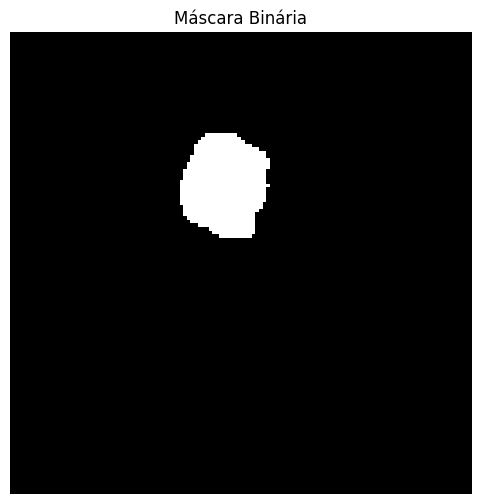

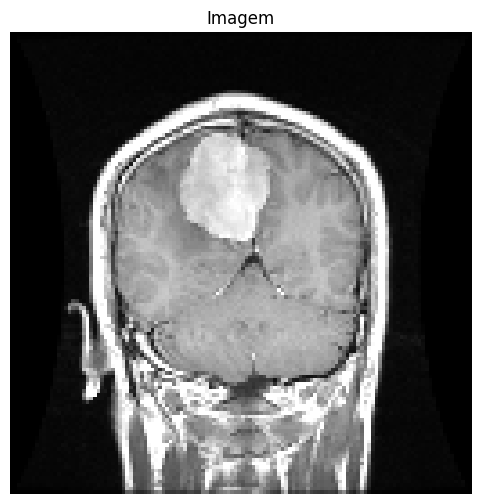

In [ ]:
import matplotlib.pyplot as plt

idx = 24
example_mask = train_masks[idx]
example_img = train_images[idx]

plt.figure(figsize=(6,6))
plt.imshow(example_mask, cmap='gray')
plt.title('Máscara Binária')
plt.axis('off')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(example_img, cmap='gray')
plt.title('Imagem')
plt.axis('off')
plt.show()

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.losses import BinaryCrossentropy

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Definição da função de perda combinada
def combined_loss(y_true, y_pred):
    return BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred)

# IoU (Intersection over Union)
def iou_metric(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return K.mean((intersection + 1e-7) / (union + 1e-7), axis=0)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.models import Model

def unet_model(img_size):
    inputs = Input(shape=(*img_size, 1))
    
    c1 = Conv2D(16*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.4)(c1)
    c1 = Conv2D(16*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D()(c1)
    
    c2 = Conv2D(32*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.4)(c2)
    c2 = Conv2D(32*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D()(c2)
    
    c3 = Conv2D(64*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.4)(c3)
    c3 = Conv2D(64*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D()(c3)
    
    c4 = Conv2D(128*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.4)(c4)
    c4 = Conv2D(128*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D()(c4)
    
    c5 = Conv2D(256*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.4)(c5)
    c5 = Conv2D(256*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    
    u6 = Conv2DTranspose(128*2, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.4)(c6)
    c6 = Conv2D(128*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    
    u7 = Conv2DTranspose(64*2, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.4)(c7)
    c7 = Conv2D(64*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    
    u8 = Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.4)(c8)
    c8 = Conv2D(32*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    
    u9 = Conv2DTranspose(16*2, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.4)(c9)
    c9 = Conv2D(16*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)
    
    # Saída
    outputs = Conv2D(1, 1, activation='sigmoid')(c9)
    
    model = Model(inputs, outputs)
    return model


In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 1e-4

#Cria e compilar o modelo
stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
best = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
model = unet_model(img_size)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=combined_loss, metrics=['accuracy', iou_metric])

history = model.fit(
    train_images, train_masks,
    validation_data=(test_images, test_masks),
    epochs=500,
    batch_size=batch_size//2,
    callbacks=[stop, best]
)
print("Treinamento concluído!")

Epoch 1/500
307/307 [==============================] - 52s 125ms/step - loss: 1.6487 - accuracy: 0.6316 - iou_metric: 0.0183 - val_loss: 1.5313 - val_accuracy: 0.9444 - val_iou_metric: 0.0183
Epoch 2/500
307/307 [==============================] - 32s 104ms/step - loss: 1.4751 - accuracy: 0.9160 - iou_metric: 0.0266 - val_loss: 1.5362 - val_accuracy: 0.8967 - val_iou_metric: 0.0220
Epoch 3/500
307/307 [==============================] - 32s 106ms/step - loss: 1.3200 - accuracy: 0.9694 - iou_metric: 0.0379 - val_loss: 1.2566 - val_accuracy: 0.9750 - val_iou_metric: 0.0270
Epoch 4/500
307/307 [==============================] - 32s 106ms/step - loss: 1.1798 - accuracy: 0.9770 - iou_metric: 0.0522 - val_loss: 1.1468 - val_accuracy: 0.9838 - val_iou_metric: 0.0341
Epoch 5/500
307/307 [==============================] - 33s 107ms/step - loss: 1.0507 - accuracy: 0.9815 - iou_metric: 0.0751 - val_loss: 1.0364 - val_accuracy: 0.9827 - val_iou_metric: 0.0637
Epoch 6/500
307/307 [===================

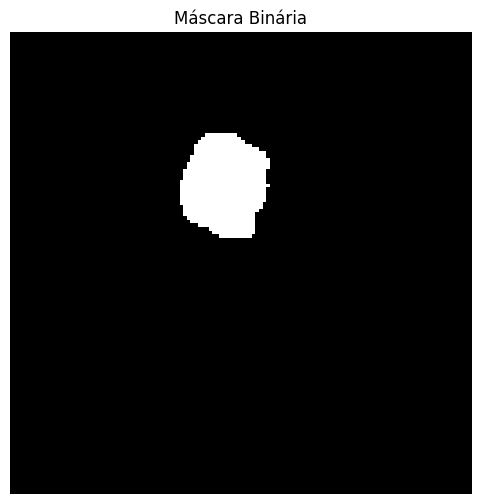

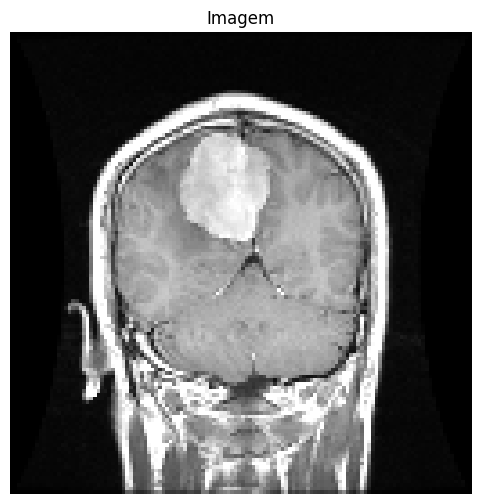

In [ ]:
import matplotlib.pyplot as plt

idx = 24
example_mask = train_masks[idx]
example_img = train_images[idx]

plt.figure(figsize=(6,6))
plt.imshow(example_mask, cmap='gray')
plt.title('Máscara Binária')
plt.axis('off')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(example_img, cmap='gray')
plt.title('Imagem')
plt.axis('off')
plt.show()

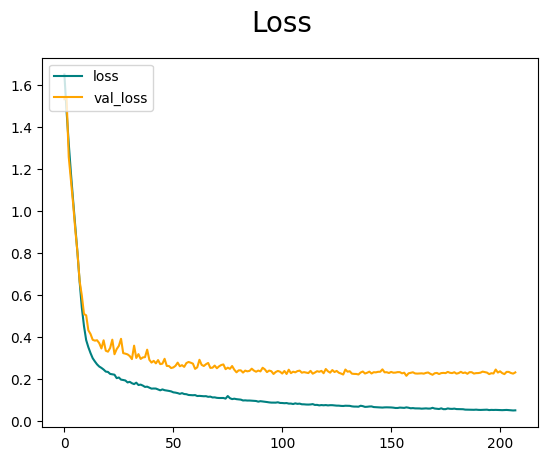

In [56]:
# SE LOSS DESCER E VAL LOSS SUBIR = OVERFITTING
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

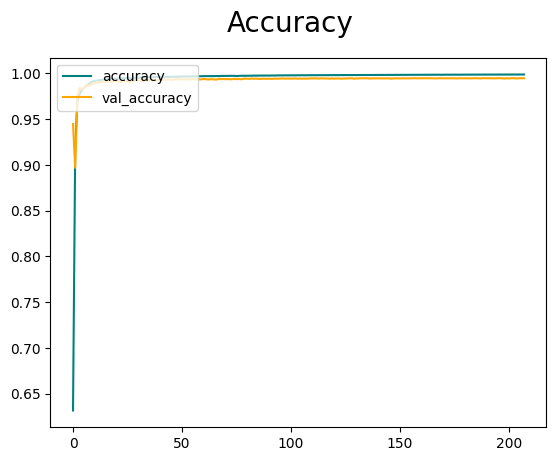

In [57]:
# TESTA ACERTO
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [58]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

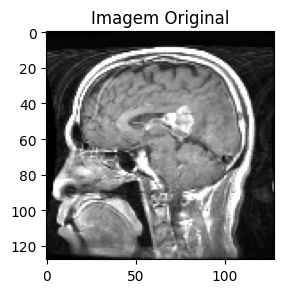

In [59]:
plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1)
plt.title('Imagem Original')
plt.imshow(tf.squeeze(test_images[6]), cmap='gray')
plt.show()

In [60]:
def plot_sample(image, mask, pred_mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title('Imagem Original')
    plt.imshow(tf.squeeze(image), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Máscara Real')
    plt.imshow(tf.squeeze(mask), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Predição U-Net')
    plt.imshow(tf.squeeze(pred_mask), cmap='gray')

    plt.show()

In [61]:
import tensorflow as tf
import numpy as np

def calc_accuracy(mask, pred_mask):
    mask = tf.round(mask)
    pred_mask = tf.round(pred_mask)
    intersection = tf.reduce_sum(mask * pred_mask)
    union = tf.reduce_sum(mask) + tf.reduce_sum(pred_mask)
    accuracy = 2.0 * intersection / union
    return accuracy.numpy()

accuracy = 0
tam = len(test_masks)
tamreal = 0
i = 8
sample_image = test_images[i]
sample_mask = test_masks[i]
pred_mask = model.predict(tf.expand_dims(sample_image, axis=0))
dice_accuracy = 0
for i in range(tam):
    sample_image = test_images[i]
    sample_mask = test_masks[i]
    pred_mask = model.predict(tf.expand_dims(sample_image, axis=0))
    acc = calc_accuracy(sample_mask, pred_mask)
    if not np.isnan(acc):
        dice_accuracy = dice_accuracy + acc
        tamreal = tamreal + 1
        print(f"previsao  {tamreal} de {i} imagem: {acc:.2%}")
    # else:
    #     dice_accuracy = dice_accuracy + 1
    #     tamreal = tamreal + 1
    #     print(f"previsao  {tamreal} de {i} imagem: {acc:.2%} que é igual a 100%")

dice_accuracy = dice_accuracy/tamreal
print(f"Dice médio accuracy: {dice_accuracy:.2%}")

previsao  1 de 0 imagem: 94.74%
previsao  2 de 1 imagem: 85.00%
previsao  3 de 2 imagem: 64.00%
previsao  4 de 3 imagem: 29.92%
previsao  5 de 4 imagem: 72.81%
previsao  6 de 5 imagem: 95.08%
previsao  7 de 6 imagem: 92.49%
previsao  8 de 7 imagem: 90.01%
previsao  9 de 8 imagem: 90.15%
previsao  10 de 9 imagem: 62.41%
previsao  11 de 10 imagem: 34.58%
previsao  12 de 11 imagem: 89.61%
previsao  13 de 12 imagem: 95.05%
previsao  14 de 13 imagem: 88.14%
previsao  15 de 14 imagem: 49.28%
previsao  16 de 15 imagem: 94.81%
previsao  17 de 16 imagem: 69.94%
previsao  18 de 17 imagem: 95.79%
previsao  19 de 18 imagem: 70.32%
previsao  20 de 19 imagem: 31.96%
previsao  21 de 20 imagem: 0.00%
previsao  22 de 21 imagem: 61.54%
previsao  23 de 22 imagem: 0.00%
previsao  24 de 23 imagem: 84.09%
previsao  25 de 24 imagem: 85.38%
previsao  26 de 25 imagem: 91.23%
previsao  27 de 26 imagem: 81.52%
previsao  28 de 27 imagem: 96.18%
previsao  29 de 28 imagem: 97.07%
previsao  30 de 29 imagem: 91.96%
p

In [ ]:
# Calcula a média do Dice accuracy
print(f"Dice médio accuracy: {dice_accuracy:.2%}")

Dice médio accuracy: 79.51%


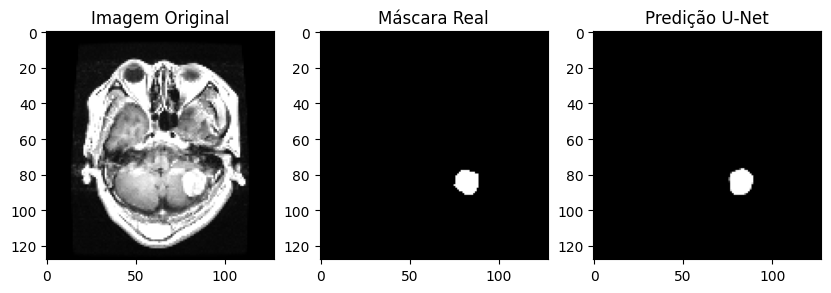

Porcentagem de acerto: 91.96%


In [ ]:
sample_idx = 29
sample_image = test_images[sample_idx]
sample_mask = test_masks[sample_idx]
pred_mask = model.predict(tf.expand_dims(sample_image, axis=0))

# Calcula a porcentagem de acerto de uma unica imagem
def calc_accuracy(mask, pred_mask):
    mask = tf.round(mask)
    pred_mask = tf.round(pred_mask)
    intersection = tf.reduce_sum(mask * pred_mask)
    union = tf.reduce_sum(mask) + tf.reduce_sum(pred_mask)
    accuracy = 2.0 * intersection / union
    return accuracy.numpy()

accuracy = calc_accuracy(sample_mask, pred_mask)

# Exibir o resultado
plot_sample(sample_image, sample_mask, pred_mask[0])
print(f"Porcentagem de acerto: {accuracy:.2%}")

In [64]:
model.save(r'models\model7.h5')